# Dimensional reduction

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model,manifold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
import seaborn as sns
import pylab
#Project functions
from Project_functions import get_monthi,get_mean_temp

In [3]:
#setup
df = pd.read_csv("consumption.csv")
weather_avg = pd.read_csv('weather-avg.csv')
weather_min = pd.read_csv('weather-min.csv')
weather_max = pd.read_csv('weather-max.csv')
info = pd.read_csv('addinfo.csv')
weather_avg = weather_avg.set_index("meter_id")
weather_min = weather_min.set_index("meter_id")
weather_max = weather_max.set_index("meter_id")
info = info.set_index("meter_id")
weather_avg_sorted = weather_avg.reindex(df.iloc[:,0])
weather_min_sorted = weather_min.reindex(df.iloc[:,0])
weather_max_sorted = weather_max.reindex(df.iloc[:,0])
info_sorted = info.reindex(df.iloc[:,0])
brinfo=info_sorted['num_bedrooms']
values = {'num_bedrooms' : brinfo.mean()}
info_filled_br = info_sorted.fillna(value = values)
brinfo_filled = info_filled_br['num_bedrooms']

In [26]:
#these don't work out of the function file apperantly
def Eval_random_Split(features,npEn_con,split,model,print_res=True):
    X_train, X_test, y_train, y_test = train_test_split(
    features , npEn_con.reshape(-1,1), test_size=split, random_state=0)
    #print(X_train.shape, y_train.shape)
    #print(X_test.shape, y_test.shape)
    model.fit(X_train,y_train)
    if print_res:
        y_pred=model.predict(X_test)
        print('Coefficients: \n', model.coef_)
        print('Intercept: {}'.format(model.intercept_))
        # The mean squared error
        print('Mean squared error: %.8f' % mean_squared_error(y_test, y_pred))
        # The coefficient of determination: 1 is perfect prediction
        print('Coefficient of determination: %.8f' % r2_score(y_test, y_pred))
    return model

def Check_1D(features,npEn_con,split,model,print_res=True):
    #extract only the last month from the features
    features_lm=features[:,(features.shape[-1]-1)]
    features_lm=features_lm.reshape(-1,1)
    #use previously made function
    return Eval_random_Split(features_lm,npEn_con,split,model,print_res)

#z-normalization on data:
def normalise_features(np_features):
    #np_features_norm= np.zeros(shape = np_features.shape)
    np_features_norm=np_features
    if np_features.ndim==1:
        np_features_norm=(np_features-np.mean(np_features))/np.std(np_features)
    else: 
        for i in range(np_features.shape[1]):
            np_features_norm[:,i] = (np_features[:,i]-np.mean(np_features[:,i]))/np.std(np_features[:,i])
    return np_features_norm

def Eval_Kfold_Split(features,npEn_con,n_splits,model,print_res=True):
    kf = KFold(n_splits, shuffle=True)
    models_arr=[]
    MSE_arr=[]
    R2_arr=[]
    for train_index, test_index in kf.split(features): 
        cmodel=model
        cmodel.fit(features[train_index,],npEn_con[train_index])
        models_arr.append(cmodel)
        y_pred = model.predict(features[test_index,])
        MSE_arr.append(mean_squared_error(npEn_con[test_index,], y_pred));
        R2_arr.append(r2_score(npEn_con[test_index,], y_pred))
    if print_res:
        # The mean squared error
        print('Mean squared error:')
        print(np.mean(MSE_arr))
        # The coefficient of determination: 1 is perfect prediction
        print('Coefficient of determination: ' )
        print(np.mean(R2_arr))
    return models_arr

In [43]:
def sort_data(nim,nom,combine_output=False):
    #nim: number of input months
    #nom: number of output months
    
    #CHECK INPUTS
    if nim<1:
        print("number of input months (nim) should be greater or equal to 1")
        return 0
    if nom<1:
        print("number of output months (nom) should be greater or equal to 1")
        return 0
    
    #DATA STORAGE
    En_con=[]        #current/future consumption (this is what we try to predict)
    prev_con=[]      #previous consumption
    prev_daily_con=[]  #previous consumption on a daily basis
    #extra info
    temps=[]
    temps_min=[]
    temps_max=[]
    month_arr=[]
    br_arr=[]       #Bedroom info array
    br_arr_mean=[]
    dwt_arr=[]      #dwelling type array
    y = pd.get_dummies(info_sorted.dwelling_type, prefix='dwelling_type')
    
    #LOOP
    NaN_t=1200  #thershold
    #NaN_day_T=20 #the amount of days of data we want in a input month(28 days)
    for i in range(df.shape[0]): # loop over all users
        meter=df.iloc[i] # = row number i  
    
        #loop over all month from januari until month 14-nim-nom
        #if the month is higher then this we don't have enough data for the nim input and nom output variables
        #in the case of nim=1 nom=1 we get range(1,12) wich result in m going from 1 to 11 like we want
        for m in range (1,14-nim-nom): 
            #load current month
            bi, ei =get_monthi(m)    #bi (begin index) ei(end index)
            month=meter[bi:ei]       #data for the month m for the row user (row) i
            #load bedroom info
            row = brinfo[i:i+1]               #bedroom info with NaN values
            row_mean = brinfo_filled[i:i+1]  #bedroom info with mean values
            #Load dwelling type
            dew_type_row = y[i:i+1]
            
            # Count the amount of NaN's in all months that will be used
            n_NaN=0
            for k in range(nim+nom):
                bi, ei =get_monthi(m+k)        #bi (begin index) ei(end index)
                tempmonth=meter[bi:ei]       #data for the month m for the row user (row) i
                n_NaN+=tempmonth.isnull().sum() 
            
            if n_NaN<NaN_t:
                #save input for month j,j+1,..,j+nim-1
                input_months=np.zeros(nim)
                input_days=np.zeros([nim,28])
                output_months=np.zeros(nom)
                for k in range(nim):
                    #load month for input j+k (k goes from 0 to nim-1)
                    bik,eik=get_monthi(m+k)
                    input_months[k]=meter[bik:eik].mean()
                    daily_con=np.zeros(28)
                    current_month=meter[bik:eik]
                    #print(current_month)
                    #save daily data
                    for d in range(28):
                        daily_con[d]=current_month[d*48:(d+1)*48].mean()
                        input_days[k,:]=daily_con
                    #replace all NaN with the mean value
                    input_days[k,np.isnan(input_days[k,:])]=input_months[k] 
                for k in range(nom):
                    #load month for input j+nim+k
                    bik,eik=get_monthi(m+nim+k)
                    output_months[k]=meter[bik:eik].mean()
                #debug if statement checks for NaN in input month
                if np.isnan(np.sum(input_months)):
                    print("input month has nan value for months=%i index=%i" %(m,i))
                    print(input_months)
                    return 1
                if np.isnan(np.sum(np.sum(input_days))):
                    print("input days has nan value for months=%i index=%i" %(m,i))
                    print(input_days)
                    return 1
                if np.isnan(np.sum(output_months)):
                    print("Output months has nan value for months=%i index=%i" %(m,i))
                    print(output_months)
                    return 1
                #store Energy consumption data
                prev_con.append(input_months)
                prev_daily_con.append(input_days)
                En_con.append(output_months)
                #save extra information 
                temps.append(get_mean_temp(weather_avg_sorted.iloc[i:i+1],m+nim))
                temps_min.append(get_mean_temp(weather_min_sorted.iloc[i:i+1],m+nim))
                temps_max.append(get_mean_temp(weather_max_sorted.iloc[i:i+1],m+nim))
                month_arr.append(m+nim)
                #bedroom info
                n_br=row[0]
                br=np.zeros(5)
                if ~np.isnan(n_br):
                    #print(n_br)
                    br[np.int(n_br-1)]=1
                br_arr.append(br)
                br_arr_mean.append(row_mean[0])
                #dwelling type
                dwt_arr.append(dew_type_row.to_numpy().ravel())
                        
                #break out of outer month loops since the inner month loop takes care of all months
                #break
                
    # converting list to numpy arrays: 
    npEn_con=np.array(En_con)
    npprev_con=np.array(prev_con)
    npprev_daily_con=np.array(prev_daily_con)
    nptemps=np.array(temps)
    nptemps_min=np.array(temps_min)
    nptemps_max=np.array(temps_max)
    npmonth=np.array(month_arr)
    npbr=np.array(br_arr)
    npbrmean=np.array(br_arr_mean)
    npdwt=np.array(dwt_arr)
    
    #This should probably be done differently 
    if combine_output:
        return [npEn_con,npprev_con,npprev_daily_con,nptemps,nptemps_min,nptemps_max,npmonth,npbr,npbrmean,npdwt]
    else:
        return npEn_con,npprev_con,npprev_daily_con,nptemps,nptemps_min,nptemps_max,npmonth,npbr,npbrmean,npdwt

In [44]:
data11=sort_data(1,1,combine_output=True)

In [45]:
#quick comparison to previous results
print(data11[2].shape)
#1 month of previous data
Eval_random_Split(data11[1],data11[0],0.3,LinearRegression())
model=Eval_Kfold_Split(data11[1],data11[0],10,LinearRegression())
print("1 months")
np_features=np.column_stack(((data11[1],data11[3],data11[4],data11[5],data11[8],data11[9])))
models_arr=Eval_Kfold_Split(np_features,data11[0],10,LinearRegression())

(17755, 1, 28)
Coefficients: 
 [[1.00055983]]
Intercept: [0.00965907]
Mean squared error: 0.00328998
Coefficient of determination: 0.84293544
Mean squared error:
0.003282072448243819
Coefficient of determination: 
0.8358202278194437
1 months
Mean squared error:
0.003090997214828124
Coefficient of determination: 
0.8448039770809744


In [41]:
#quick try of daily data
Eval_random_Split(data11[2],data11[0],0.3,LinearRegression())
model=Eval_Kfold_Split(data11[2],data11[0],10,LinearRegression())
print("1 months")
np_features=np.column_stack(((data11[2],data11[3],data11[4],data11[5],data11[8],data11[9])))
models_arr=Eval_Kfold_Split(np_features,data11[0],10,LinearRegression())

Coefficients: 
 [[1.00055983]]
Intercept: [0.00965907]
Mean squared error: 0.00328998
Coefficient of determination: 0.84293544
Mean squared error:
0.003280850744616072
Coefficient of determination: 
0.8360493032182825
1 months
Mean squared error:
0.0030941616492241525
Coefficient of determination: 
0.8455897920670689


<AxesSubplot:>

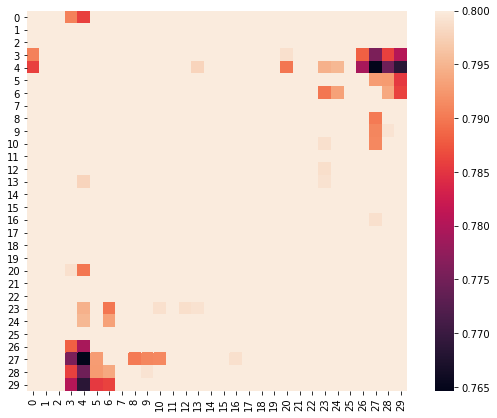

In [63]:
#stolen from practical session
#df2 = pd.DataFrame(np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]]),
#                   columns=['a', 'b', 'c'])
# test=np.column_stack(((data11[1],data11[0],data11[:,1])))
# df2 = pd.DataFrame(test,columns=['Energy consumption', 'daily consumption','daily con'])
test=np.column_stack(((data11[0],data11[1],data11[2][:,0,:])))
df2=pd.DataFrame(test)
corrmat = df2.corr()
f, ax = plt.subplots(figsize=(10, 7))
sns.heatmap(corrmat, vmax=.8, square=True)

## PCA

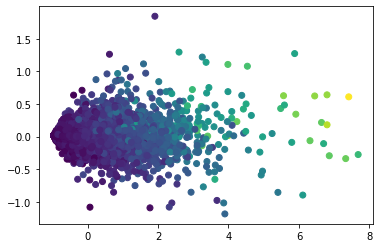

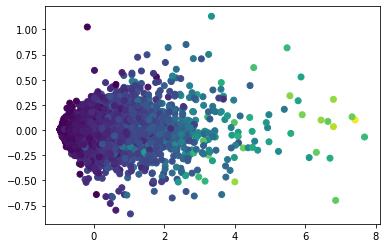

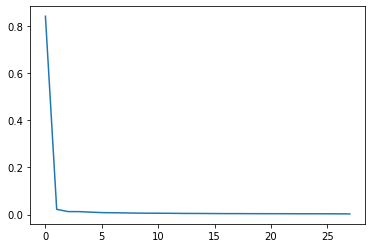

In [90]:
data=data11
pca = PCA()
pca_dims = pca.fit_transform(data[2][:,0,:])
# 1st and 2nd PCs:
pylab.scatter(pca_dims[:,0],pca_dims[:,1], c=data[0])  # Dimension 0 and 1
pylab.show()
pylab.scatter(pca_dims[:,0],pca_dims[:,2], c=data[0])  # Dimension 0 and 2
pylab.show()
pylab.plot(pca.explained_variance_ratio_)
pylab.show()

In [86]:
data=data11
print("################# \npaca dim 0")
np_features=np.column_stack((pca_dims[:,0],data[3],data[4], data[5], data11[8],data11[9]))
npEn_con1=data[0]
np_features_norm=normalise_features(np_features)
npEn_con1_norm=normalise_features(npEn_con1)
models_arr=Eval_Kfold_Split(np_features_norm,npEn_con1_norm,10,LinearRegression())
print("################# \npaca dim 0 1")
np_features=np.column_stack((pca_dims[:,0],pca_dims[:,1],data[3],data[4], data[5], data11[8],data11[9]))
npEn_con1=data[0]
np_features_norm=normalise_features(np_features)
npEn_con1_norm=normalise_features(npEn_con1)
models_arr=Eval_Kfold_Split(np_features_norm,npEn_con1_norm,10,LinearRegression())
print("################# \npaca dim 0 1 2")
np_features=np.column_stack((pca_dims[:,0],pca_dims[:,1],pca_dims[:,2],data[3],data[4], data[5], data11[8],data11[9]))
npEn_con1=data[0]
np_features_norm=normalise_features(np_features)
npEn_con1_norm=normalise_features(npEn_con1)
models_arr=Eval_Kfold_Split(np_features_norm,npEn_con1_norm,10,LinearRegression())
print("################# \npaca dim 0 1 2")
np_features=np.column_stack((pca_dims[:,[0,1,2]],data[3],data[4], data[5], data11[8],data11[9]))
npEn_con1=data[0]
np_features_norm=normalise_features(np_features)
npEn_con1_norm=normalise_features(npEn_con1)
models_arr=Eval_Kfold_Split(np_features_norm,npEn_con1_norm,10,LinearRegression())
print("################# \npaca dim 0 1 2 3")
np_features=np.column_stack((pca_dims[:,[0,1,2,3]],data[3],data[4], data[5], data11[8],data11[9]))
npEn_con1=data[0]
np_features_norm=normalise_features(np_features)
npEn_con1_norm=normalise_features(npEn_con1)
models_arr=Eval_Kfold_Split(np_features_norm,npEn_con1_norm,10,LinearRegression())
print("################# \npaca dim 0 1 2 3 4")
np_features=np.column_stack((pca_dims[:,[0,1,2,3,4]],data[3],data[4], data[5], data11[8],data11[9]))
npEn_con1=data[0]
np_features_norm=normalise_features(np_features)
npEn_con1_norm=normalise_features(npEn_con1)
models_arr=Eval_Kfold_Split(np_features_norm,npEn_con1_norm,10,LinearRegression())

################# 
paca dim 0
Mean squared error:
0.1634350813976539
Coefficient of determination: 
0.8361738001660637
################# 
paca dim 0 1
Mean squared error:
0.1500721025758989
Coefficient of determination: 
0.8505434162818591
################# 
paca dim 0 1 2
Mean squared error:
0.1493297883923723
Coefficient of determination: 
0.8503821428162501
################# 
paca dim 0 1 2
Mean squared error:
0.14912900366860757
Coefficient of determination: 
0.8501550552501843
################# 
paca dim 0 1 2 3
Mean squared error:
0.14942016994564677
Coefficient of determination: 
0.8500901889377049
################# 
paca dim 0 1 2 3 4
Mean squared error:
0.14807418478451714
Coefficient of determination: 
0.8517617867112112


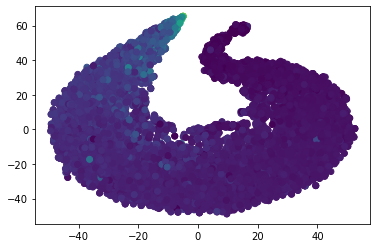

In [76]:
x_tsne = manifold.TSNE(n_components=2).fit_transform(data[2][:,0,:])
pylab.scatter(x_tsne[:,0], x_tsne[:,1], c=data[0])
pylab.show()

looks cool i guess

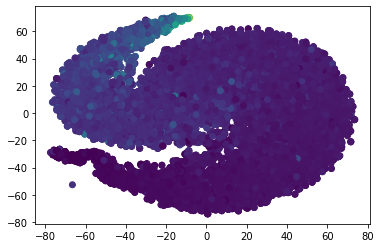

In [77]:
x_tsne = manifold.TSNE(n_components=2,perplexity=10).fit_transform(data[2][:,0,:])
pylab.scatter(x_tsne[:,0], x_tsne[:,1], c=data[0])
pylab.show()

In [78]:
data21=sort_data(2,1,combine_output=True)

In [79]:
data21[2].shape

(14702, 2, 28)

<AxesSubplot:>

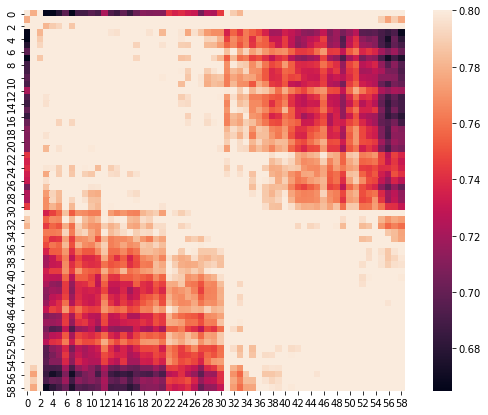

In [80]:
test=np.column_stack(((data21[0],data21[1],data21[2][:,0,:],data21[2][:,1,:])))
df2=pd.DataFrame(test)
corrmat = df2.corr()
f, ax = plt.subplots(figsize=(10, 7))
sns.heatmap(corrmat, vmax=.8, square=True)

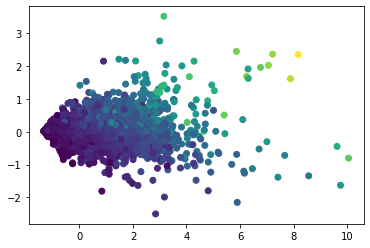

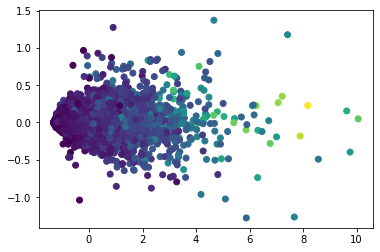

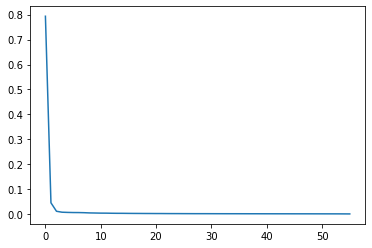

In [97]:
data=data21
daily_stuff=np.column_stack((data[2][:,0,:],data[2][:,1,:]))
pca = PCA()
pca_dims2 = pca.fit_transform(daily_stuff)
# 1st and 2nd PCs:
pylab.scatter(pca_dims2[:,0],pca_dims2[:,1], c=data[0])  # Dimension 0 and 1
pylab.show()
pylab.scatter(pca_dims2[:,0],pca_dims2[:,2], c=data[0])  # Dimension 0 and 2
pylab.show()
pylab.plot(pca.explained_variance_ratio_)
pylab.show()

In [98]:
data=data21
print("################# \npca dim 0")
np_features=np.column_stack((pca_dims2[:,0],data[3],data[4], data[5], data11[8],data11[9]))
npEn_con1=data[0]
np_features_norm=normalise_features(np_features)
npEn_con1_norm=normalise_features(npEn_con1)
models_arr=Eval_Kfold_Split(np_features_norm,npEn_con1_norm,10,LinearRegression())
print("################# \npca dim 0 1")
np_features=np.column_stack((pca_dims[:,0],pca_dims[:,1],data[3],data[4], data[5], data11[8],data11[9]))
npEn_con1=data[0]
np_features_norm=normalise_features(np_features)
npEn_con1_norm=normalise_features(npEn_con1)
models_arr=Eval_Kfold_Split(np_features_norm,npEn_con1_norm,10,LinearRegression())
print("################# \npca dim 0 1 2")
np_features=np.column_stack((pca_dims[:,0],pca_dims[:,1],pca_dims[:,2],data[3],data[4], data[5], data11[8],data11[9]))
npEn_con1=data[0]
np_features_norm=normalise_features(np_features)
npEn_con1_norm=normalise_features(npEn_con1)
models_arr=Eval_Kfold_Split(np_features_norm,npEn_con1_norm,10,LinearRegression())
print("################# \npca dim 0 1 2")
np_features=np.column_stack((pca_dims[:,[0,1,2]],data[3],data[4], data[5], data11[8],data11[9]))
npEn_con1=data[0]
np_features_norm=normalise_features(np_features)
npEn_con1_norm=normalise_features(npEn_con1)
models_arr=Eval_Kfold_Split(np_features_norm,npEn_con1_norm,10,LinearRegression())
print("################# \npca dim 0 1 2 3")
np_features=np.column_stack((pca_dims[:,[0,1,2,3]],data[3],data[4], data[5], data11[8],data11[9]))
npEn_con1=data[0]
np_features_norm=normalise_features(np_features)
npEn_con1_norm=normalise_features(npEn_con1)
models_arr=Eval_Kfold_Split(np_features_norm,npEn_con1_norm,10,LinearRegression())
print("################# \npca dim 0 1 2 3 4")
np_features=np.column_stack((pca_dims[:,[0,1,2,3,4]],data[3],data[4], data[5], data11[8],data11[9]))
npEn_con1=data[0]
np_features_norm=normalise_features(np_features)
npEn_con1_norm=normalise_features(npEn_con1)
models_arr=Eval_Kfold_Split(np_features_norm,npEn_con1_norm,10,LinearRegression())

################# 
pca dim 0


ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 14702 and the array at index 4 has size 17755